# Assignment Collective Intelligence Week 7: Information retrieval

## Notebook made by   (If not filled in correctly: 0 pts for assignment)

__Name(s)__: 

__Student id(s)__ : 

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )

Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file.

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='link to your selfie'/>

In [2]:
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
import os
import glob
import nltk
import math
from __future__ import division


import requests
import urllib
from string import punctuation

**Q1** Make a couple of functions which do the following:

1. Download all these files: <http://www.ibiblio.org/xml/examples/shakespeare/>, and store them locally in a folder.
2. Make a function `index_collection(folder)` which reads in each file `f` in that folder, and returns a dict with words as keys and as values a dict with filenames as keys and how often the word occurs in the filename as values. So:
    1. Extract the text
    3. tokenize and lower case that text
    2. for each token `w`: how often `w` occurs in `f`



In [3]:
def get_files1(url):
    !wget -r -np $url

def get_files2(url):
    soup = BeautifulSoup(requests.get(url).text)
    loc = [url + i.get('href') for i in soup.find_all('a') if 'xml' in i.get('href')]

    for i in loc:
        urllib.URLopener().retrieve(i, 'shakespeare/' + i[48:])

In [4]:
path_to_my_folder = 'shakespeare'

In [5]:
def index_collection(folder):
    MyIndex = {}
    filenames = [f for f in glob.iglob(folder + '/*.xml')]
    
    for i in filenames:
        text = BeautifulSoup(open(i)).text
        tokens = [j.lower().encode('UTF-8') for j in nltk.word_tokenize(text) if j not in punctuation]
        fd = Counter(tokens)
        

        for word in fd:
            try:
                MyIndex[word].update({i[12:]: fd[word]})
            except KeyError:
                MyIndex[word] = {i[12:]: fd[word]}
                
    return MyIndex

In [6]:
# try it out 
shakespeare = index_collection(path_to_my_folder)

# Now I can call 
shakespeare['love']
# and obtain a dict of filename:count pairs

{'a_and_c.xml': 39,
 'all_well.xml': 63,
 'as_you.xml': 115,
 'com_err.xml': 18,
 'coriolan.xml': 29,
 'cymbelin.xml': 30,
 'dream.xml': 109,
 'hamlet.xml': 67,
 'hen_iv_1.xml': 28,
 'hen_iv_2.xml': 21,
 'hen_v.xml': 40,
 'hen_vi_1.xml': 26,
 'hen_vi_2.xml': 17,
 'hen_vi_3.xml': 40,
 'hen_viii.xml': 24,
 'j_caesar.xml': 34,
 'john.xml': 40,
 'lear.xml': 52,
 'lll.xml': 110,
 'm_for_m.xml': 29,
 'm_wives.xml': 45,
 'macbeth.xml': 19,
 'merchant.xml': 58,
 'much_ado.xml': 91,
 'othello.xml': 79,
 'pericles.xml': 26,
 'r_and_j.xml': 146,
 'rich_ii.xml': 33,
 'rich_iii.xml': 66,
 't_night.xml': 77,
 'taming.xml': 63,
 'tempest.xml': 12,
 'timon.xml': 34,
 'titus.xml': 23,
 'troilus.xml': 70,
 'two_gent.xml': 165,
 'win_tale.xml': 24}

**Q2**  Change your function `index_collection(folder)` so that it also stores the document frequency of each word: as follows

```
shakespeare['macbeth'] = (document_frequency of 'macbeth', dict of filename:count pairs)
```

In [7]:
def index_collection_plusDF(folder):
    docfreq = index_collection(folder)
    filenames = [f for f in glob.iglob(folder + '/*.xml')]
    MyIndex = {i: (len(docfreq[i]) / len(filenames), docfreq[i]) 
               for i in docfreq}
    
    return MyIndex

In [8]:
shakespeare_df = index_collection_plusDF(path_to_my_folder)

In [9]:
shakespeare_df['love']

(1.0,
 {'a_and_c.xml': 39,
  'all_well.xml': 63,
  'as_you.xml': 115,
  'com_err.xml': 18,
  'coriolan.xml': 29,
  'cymbelin.xml': 30,
  'dream.xml': 109,
  'hamlet.xml': 67,
  'hen_iv_1.xml': 28,
  'hen_iv_2.xml': 21,
  'hen_v.xml': 40,
  'hen_vi_1.xml': 26,
  'hen_vi_2.xml': 17,
  'hen_vi_3.xml': 40,
  'hen_viii.xml': 24,
  'j_caesar.xml': 34,
  'john.xml': 40,
  'lear.xml': 52,
  'lll.xml': 110,
  'm_for_m.xml': 29,
  'm_wives.xml': 45,
  'macbeth.xml': 19,
  'merchant.xml': 58,
  'much_ado.xml': 91,
  'othello.xml': 79,
  'pericles.xml': 26,
  'r_and_j.xml': 146,
  'rich_ii.xml': 33,
  'rich_iii.xml': 66,
  't_night.xml': 77,
  'taming.xml': 63,
  'tempest.xml': 12,
  'timon.xml': 34,
  'titus.xml': 23,
  'troilus.xml': 70,
  'two_gent.xml': 165,
  'win_tale.xml': 24})

**Q3** Create a function `query(index,string)` which does information retrieval on a created index.

1. It first tokenizes string into a list `L` of keywords .
2. Then it computes `sum(score(w,doc) for w in L)` for each document `doc` in our collection.
3. `score(w,doc)` is simply `(TF(w,doc) * IDF(w)) `, where `TF(w,doc)` is the raw frequency of `w` in `doc` and `IDF(w)` is the inverse document frequency as defined in [G. Adomavicius and A. Tuzhilin. "Towards the Next Generation of Recommender Systems: A Survey of the State-of-the-Art and Possible Extensions." IEEE Transactions on Knowledge and Data Engineering, vol. 17, no. 6, June 2005. ](http://web.stanford.edu/class/ee378b/papers/adomavicius-recsys.pdf) 
4. The output is a list of `(score,filename)` pairs sorted on `score`. 

In [32]:
def score(w, doc, index):
    if index[w][0] == 1.0: # w exists in all documents
        return 0.0
    
    elif doc not in index[w][1]: # w doesn't exist in given doc
        return 0.0
    
    else:
        TF = index[w][1][doc] / sum(index[i][1][doc] for i in index if doc in index[i][1]) # normalised
        #TF = index[w][1][doc]
        IDF =  math.log(1/index[w][0])
        return TF * IDF

def query(index, string):    
    docs = [i[12:] for i in glob.iglob('shakespeare/*.xml')]
    L = [i.lower() for i in nltk.word_tokenize(string) if i not in punctuation]

    return sorted([(sum(score(w, d, index) for w in L), d) for d in docs], reverse = True)
   
# test
 
%time query(shakespeare_df, 'caesar')

CPU times: user 229 ms, sys: 40.6 ms, total: 269 ms
Wall time: 214 ms


[(0.00857561148321794, 'j_caesar.xml'),
 (0.0069610557200968405, 'a_and_c.xml'),
 (0.0004018160772575064, 'cymbelin.xml'),
 (8.290827970490239e-05, 'rich_iii.xml'),
 (5.6791694727773335e-05, 'hen_vi_1.xml'),
 (5.651239525821715e-05, 'm_for_m.xml'),
 (4.98395164313168e-05, 'hen_vi_3.xml'),
 (4.8578952110338136e-05, 'hen_vi_2.xml'),
 (4.048098478363605e-05, 'hamlet.xml'),
 (3.561772838166866e-05, 'macbeth.xml'),
 (2.996218906122028e-05, 'titus.xml'),
 (2.871763760245536e-05, 'as_you.xml'),
 (2.8433401598881568e-05, 'lll.xml'),
 (2.7666207284258364e-05, 'm_wives.xml'),
 (2.7259967012057097e-05, 'rich_ii.xml'),
 (2.6780203860561093e-05, 'all_well.xml'),
 (2.385137363482031e-05, 'hen_v.xml'),
 (2.354633221967087e-05, 'hen_iv_2.xml'),
 (2.325873088388707e-05, 'othello.xml'),
 (0.0, 'win_tale.xml'),
 (0.0, 'two_gent.xml'),
 (0.0, 'troilus.xml'),
 (0.0, 'timon.xml'),
 (0.0, 'tempest.xml'),
 (0.0, 'taming.xml'),
 (0.0, 't_night.xml'),
 (0.0, 'r_and_j.xml'),
 (0.0, 'pericles.xml'),
 (0.0, 'much_

**Q4** Argue that you have just implemented the dot-product of the query-vector and the document-vector. 

* Experiment with adding the same term multiple times to the query. What happens? Does that make sense?

### PageRank

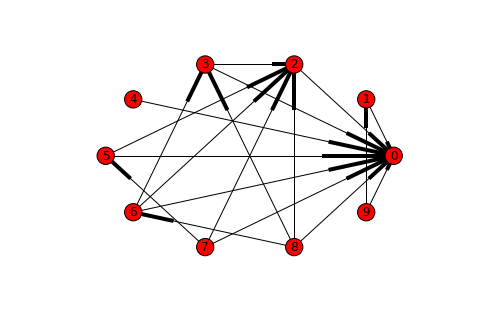

In [193]:
%matplotlib inline
import networkx as nx

# Create a typical power law directed network
H = nx.gnc_graph(10)
nx.draw(H, pos=pos, with_labels = True)


In [194]:
# compute pagerank
% time nx.pagerank(H)

CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.11 ms


{0: 0.39339965470297483,
 1: 0.06902545030082352,
 2: 0.14755026978207342,
 3: 0.07537300735901764,
 4: 0.04843901913878966,
 5: 0.062163306580145565,
 6: 0.05873223471980659,
 7: 0.04843901913878966,
 8: 0.04843901913878966,
 9: 0.04843901913878966}

In [195]:
# some handy functions
n = 9
H.out_degree(n), H.neighbors(n), H.edges(n)

(2, [0, 1], [(9, 0), (9, 1)])

In [196]:
for n in H.nodes():
    print H.neighbors(n), H.out_degree(n)

[] 0
[0] 1
[0] 1
[0, 2] 2
[0] 1
[0, 2] 2
[0, 2, 3] 3
[0, 2, 5] 3
[0, 2, 3, 6] 4
[0, 1] 2


In [197]:
[i[0] for i in H.in_edges(0)]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [198]:
## Return all nodes which point to n
def looks_at_me(H, n):
    return [k for (k, x) in H.edges() if x == n]

for n in H.nodes():
    if not looks_at_me(H, n) == []:
        print n, looks_at_me(H, n)

0 [1, 2, 3, 4, 5, 6, 7, 8, 9]
1 [9]
2 [3, 5, 6, 7, 8]
3 [6, 8]
5 [7]
6 [8]


**Q5** Use the iterative pagerank calculation in <http://en.wikipedia.org/wiki/PageRank#Iterative>
  to create a function `my_pagerank(H,iterations=20)` which calculates the pagerank of each node. The output is, just as with `nx.pagerank()` a dict with nodes as keys and pageranks as values.

There are several definitions of PageRank. The most useful is when we can view the distribution of PageRank over the nodes as a probability distribution. This means the values of all nodes have to sum to 1.

So after computing the PageRanks, normalize the values, so that they sum to one. The [wikipedia article on pagerank](http://en.wikipedia.org/wiki/PageRank) also makes this point.



In [199]:
def my_pagerank2(H, iters = 200, d =.85):
    N = len(H)
    
    # create dict at t = 0
    r = dict.fromkeys(H, 1 / N)
    
    for _ in range(iters):
        for n in r:
            n_neighbours = [i[0] for i in H.in_edges(n)]
            r[n] = (1 - d / N) + d * \
                sum(r[n2] / H.out_degree(n2) for n2 in n_neighbours)

    # normalize
    norm = sum(r.values())
    return {k: r[k] / norm for k in r}

**Q6**
Compare your result and that of networkx  by calculating the maximum squared error (= difference) over the nodes. You may even investigate the effect of the number of iterations on rather large networks.

 

In [213]:
import numpy as np
def RMSE(list1, list2):
    return math.sqrt(np.mean([(k - v) ** 2 for k, v in zip(list1, list2)]))

RMSE(my_pagerank2(H, 200).values(), nx.pagerank(H).values())

6.127602820253407e-08

**Q7** Compute the person correlation between your result and that of networkx.
* HINT: in the notebook <http://nbviewer.ipython.org/url/maartenmarx.nl/teaching/CollectieveIntelligentie/NoteBooks/InformationRetrieval.ipynb> we created a pandas series from a list, but you can just as easily in the same way create a series from a dict. Then use pandas correlation.

In [214]:
import pandas as pd

df = pd.DataFrame(my_pagerank2(H, 200), index = ['PR1']) + pd.DataFrame(nx.pagerank(H), index = ['PR2'])

print df

      0   1   2   3   4   5   6   7   8   9
PR1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
PR2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN


In [205]:
df = pd.DataFrame.from_dict

**Q8** Compare your, hopefully very declarative and short (it can be done in 5 lines of readable code) definition of pagerank with that in the Collective Intelligence book, on page 71. 

* Do you obtain different values?
* Compare readability.
* Why would you want to store this information in a database while doing the computation? 